# Классификация рукописных цифр

## Загрузка датасета MNIST с Kaggle

In [12]:
!pip install opendatasets

In [13]:
import opendatasets as od

In [14]:
od.download("https://www.kaggle.com/c/digit-recognizer/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading digit-recognizer.zip to ./digit-recognizer


100%|██████████| 15.3M/15.3M [00:00<00:00, 1.22GB/s]


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


## Импорт библиотек

In [28]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.18.0


In [15]:
print(tf.executing_eagerly())

True


## Сохраняем csv файлы в массивы

In [16]:
train = np.loadtxt('digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [17]:
print(type(train))

<class 'numpy.ndarray'>


In [18]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


## Сохраняем разметку в отдельную переменную

In [20]:
train_label = train[:, 0]

In [25]:
train_label.shape

(42000,)

In [22]:
print(train_label[:10])

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


## Приводим размерность к удобному для обработки виду

In [23]:
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

In [24]:
print(train_img.shape, test_img.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


## Визуализируем исходные данные

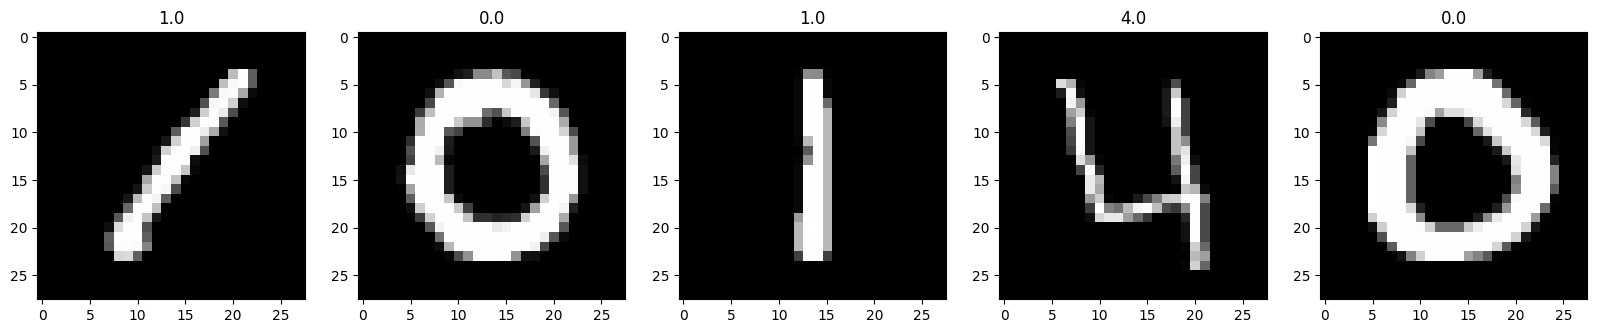

In [27]:
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:, :, 0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [29]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label,
    train_img,
    test_size=0.2,
    random_state=42
)

In [30]:
print(y_train.shape, x_train.shape)

(33600,) (33600, 28, 28, 1)


In [31]:
print(y_val.shape, x_val.shape)

(8400,) (8400, 28, 28, 1)


## Собираем сверточную сеть для обучения

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=6,
        kernel_size=(5, 5),
        padding='same',
        activation='relu',
        input_shape=x_train.shape[1:]
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        padding='valid'
    ),
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        padding='same',
        activation='relu',
        input_shape=x_train.shape[1:]
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        padding='valid'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,022 (109.46 KB)

 Trainable params: 28,022 (109.46 KB)

 Non-trainable params: 0 (0.00 B)

## One-hot кодировка разметки